Materijali zasnovani na [zvaničnom](https://www.tensorflow.org/tutorials/keras/regression) TensorFlow tutorial-u.

# Regresija: Predviđanje potrošnje goriva 

U problemu regresije, cilj je izvršiti predikciju kontinualne vrednosti
poput cene proizvoda ili visine osobe. U ovom primeru ćemo videti
kako se neuronske mreže mogu koristiti za rešavanje problema
regresije, a za te potrebe ćemo koristiti skup podataka
[Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) koji ima
podatke o potrošnji goriva za automobile iz perida 1970-1980.

In [ ]:
# Instaliramo biblioteku seaborn.
# Jedino cemo je koristiti za `pairplot` funkciju.
!pip install -q seaborn

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

## The Auto MPG skup podataka

Skup podataka je dostupan na [UCI Machine Learning](https://archive.ics.uci.edu/ml/) repozitorijumu.


### Preuzimanje podataka

Podatke možemo preuzeti pomoću `keras.utils.get_file` funkcije.

In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

Potom možemo učitati podatke koristeći `pandas` biblioteku za rad
sa tabelarnim podacima.

Od vas se ne očekuje duboko poznavanje biblioteke
`pandas` već samo nekoliko elementarnih transformacija koje će biti prikazane.
U ispitnim zadacima će podaci biti učitani (ali ne i pretprocesirani) za vas.

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

### Sređivanje podataka

Skup sadrži neke podatke koji imaju nedostajuće vrednosti.

In [ ]:
dataset.isna().sum()

Postoje različiti načini da se bori protiv nedostajućih vrednosti
(njihova aproksimacija prosekom ili drugim vrednostima i slično), ali se u ovom
kursu nećemo baviti time. U našem slučaju, izbacićemo vrste (instance) koje
imaju nedostajuće vrednosti.

In [ ]:
dataset = dataset.dropna()

### Enkodiranje kategoričkih promenljivih

Kolona `Origin` označava indeks zemlje iz koje automobil dolazi, i to:
- 1 (Sjedinjene Američke Države, USA)
- 2 (Evropa)
- 3 (Japan)

In [ ]:
# Listamo jedinstvene vrednosti u koloni (na 2 razlicita nacina)
print(dataset.Origin.unique())
print(dataset["Origin"].unique())

SAVET: Ovo je izuzetno korisna transformacija u praksi. Želimo da elemente
kolone zamenimo nekim drugim vrednosti u zavisnosti od mapiranja koje prosledimo.

In [ ]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

Vršimo dummy enkodiranje kategoričke promenljive.

In [ ]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

### Podela podataka

Podatke sada želimo da podelimo na
podatke za obučavanje i podatke za testiranje.

Podatke za testiranje ćemo koristiti za finalnu evaluaciju našeg modela.

In [ ]:
# Uzimamo 80% podataka kao podatke za obucavanje
train_dataset = dataset.sample(frac=0.8,random_state=0)

# Ostalih 20% koristimo kao podatke za testiranje
test_dataset = dataset.drop(train_dataset.index)

### Analiza podataka

Možemo međusobno uporediti atribute u našim podacima.


In [ ]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

I pogledati opšte statistike. Atribut `MPG` ignorišemo jer će nam to biti ciljna
promenljiva.

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

### Izdvajanje ciljne promenljive

Iz podataka izdvajamo ciljnu promenljivu `MPG` ([miles per gallon](https://www.carwow.co.uk/guides/running/what-is-mpg-0255)).

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Standardizacija podataka

Naši podaci su na različitim skalama pa ima smisla izvršiti njihovu
standardizaciju. Model može da radi i bez ovoga ali se otežava njegova
optimizacija kao i uvodi zavisnost o različitim skalama merenja.

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

VAŽNO: Primetite da prosek i standardnu devijaciju koristimo iz skupa
za obučavanje i kada vršimo standardizaciju podataka za trening 
**i** testiranje. Ovo je važno jer ne želimo da informacije iz skupa
podataka za testiranje koristimo na bilo koji način prilikom obučavanja
modela jer time uvodimo pristrasnost koja vodi preprilagođavanju.

## Regresioni model

### Definicija modela

Vreme je da definišemo naš model. Koristićemo `Sequential` model
koji će predstavljati jednu neuronsku mrežu sa propagacijom unapred.
Na izlazu ove mreže će biti neuron koji će davati ocenu atributa
`MPG`.

Kao funkciju greške koristićemo srednje-kvadratnu grešku
(eng. mean squared error).

Osim `Adam` optimizatora postoje razni drugi. Više o ovim stvarima na kursu
*Mašinsko učenje* na master studijama. Radi ilustracije, ovde će biti
korišćen `RMSprop` optimizator.

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

### Pregled modela

Koristeći `summary` funkciju možemo pogledati pregled definisanog modela.

In [ ]:
model.summary()

Možemo isprobati model. Uzećemo podskup od 10 primera iz skupa za obučavanje
i propustiti ih kroz mrežu.


In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

In [32]:
example_result.shape

(10, 1)

Dobijamo 10 brojeva kao predikcije.

### Obučavanje modela

Skup za obučavanje ćemo podeliti na dva nova skupa, jedan će biti skup
na kome će se zapravo vršiti obučavanje (80% originalnog skupa za obučavanje),
a validacioni skup ćemo koristiti da na kraju svake epohe evaluiramo
koliko je dobar naš model.

Obučavaćemo model 1000 epoha i čuvaćemo tačnost na podacima za
obučavanje i validaciju tokom treninga. Funkcija `fit` vraća
objekat koji sadrži neophodne podatke.


In [ ]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=1)

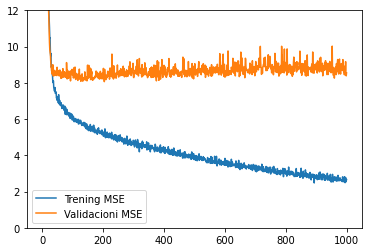

In [22]:
plt.plot(history.epoch, history.history['mse'])
plt.plot(history.epoch, history.history['val_mse'])
plt.ylim([0, 12])
plt.legend(['Trening MSE', 'Validacioni MSE'])

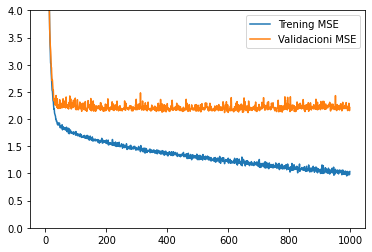

In [23]:
plt.plot(history.epoch, history.history['mae'])
plt.plot(history.epoch, history.history['val_mae'])
plt.ylim([0, 4])
plt.legend(['Trening MSE', 'Validacioni MSE'])

Dobijene podatke možemo vizuelizovati pomoću biblioteke `pandas`.
`DataFrame` je `pandas` tip koji predstavlja tabelarne podatke.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Uzimamo poslednjih 5 vrsti
hist.tail()

Možemo primetiti da je 1000 epoha previše i da puštanje obučavanja da toliko
dugo traje ne doprinosi tačnosti modela. Ponovićemo optimizacioni proces
ponovo, ali ovaj put ćemo koristiti tehniku ranog zaustavljanja
(eng. early stopping).

Ideja je definisati skup ograničenja koja kad se ispune, obučavanje modela
će biti zaustavljeno. Na primer, ukoliko se u `k` uzastopnih epoha ne
poboljša vrednost `val_mse` ima smisla zaustaviti obučavanje.

Kako odrediti parametar `k`? U pitanju je sličan problem kao i kako odrediti
arhitekturu mreže, optimizator i slično.

Više o `EarlyStopping` je dostupno [ovde](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [ ]:
model = build_model()

# Parametar `patience` je broj epoha koji se razmatra za zaustavljanje.
# Parametar `monitor` predstavlja meru koja se poredi kroz epohe.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split=0.2, verbose=1, 
                    callbacks=[early_stop])

Text(0, 0.5, 'MAE [MPG]')

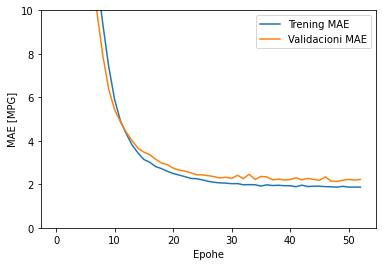

In [26]:
plt.plot(early_history.epoch, early_history.history['mae'])
plt.plot(early_history.epoch, early_history.history['val_mae'])
plt.ylim([0, 10])
plt.legend(['Trening MAE', 'Validacioni MAE'])
plt.xlabel('Epohe')
plt.ylabel('MAE [MPG]')

Graf pokazuje da je na validacionom skupu, prosečna greška oko +/- 2 MPG.
Da li je ovo dobro ili ne, zavisi od mere i slučaja upotrebe koji zavise
od problema do problema.

### Evaluacija modela

Sledeće što ćemo  uraditi je da pogledamo koliko dobro model generalizuje
na podacima za testiranje.

Ovde se stvar malko komplikuje. Treba imati u vidu da smo model do sada
obučavali na podskupu (80%) skupa za obučavanje kako bi imali validacioni skup.
Nema smisla baciti podatke (20% podataka za obučavanje koji su završili kao validacioni podataci), tako da ćemo ponovo
obučiti model, ali sada nam celokupnim podacima za obučavanje, i TAJ
model ćemo koristiti za evaluaciju na test skupu.

Postavlja se pitanje koliko epoha postaviti za obučavanje? Jedan od pristupa je
postaviti broj epoha koji je uzet prilikom ranoh zaustavljanja. U momentu
pisanja ovih materijala, na ovom primeru je to bilo 53.

In [30]:
model = build_model()

early_stop_epochs = 53

final_history = model.fit(normed_train_data, train_labels, 
                    epochs=early_stop_epochs, verbose=1)

Epoch 1/53
10/10 [==============================] - 0s 3ms/step - loss: 591.5789 - mae: 23.0428 - mse: 590.4249
Epoch 2/53
10/10 [==============================] - 0s 2ms/step - loss: 528.6136 - mae: 21.6310 - mse: 527.8847
Epoch 3/53
10/10 [==============================] - 0s 2ms/step - loss: 465.3437 - mae: 20.1757 - mse: 466.1727
Epoch 4/53
10/10 [==============================] - 0s 2ms/step - loss: 399.5216 - mae: 18.5125 - mse: 399.9228
Epoch 5/53
10/10 [==============================] - 0s 2ms/step - loss: 327.7800 - mae: 16.5621 - mse: 328.5016
Epoch 6/53
10/10 [==============================] - 0s 2ms/step - loss: 254.6235 - mae: 14.3399 - mse: 256.0094
Epoch 7/53
10/10 [==============================] - 0s 2ms/step - loss: 187.2829 - mae: 12.0422 - mse: 187.3984
Epoch 8/53
10/10 [==============================] - 0s 2ms/step - loss: 125.7946 - mae: 9.6855 - mse: 126.8701
Epoch 9/53
10/10 [==============================] - 0s 2ms/step - loss: 80.2000 - mae: 7.6095 - mse: 80.6

Konačno, možemo pogledati kako se naš model ponaša na skupu za testiranje.

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Dobijamo 1.83 MPG srednja apsolutna greška, što nije loše. Zanimljivo da je
još i manje u odnosu na validacionu grešku. Ovo je i razumno jer smo sada
koristili više podataka.

### Predviđanje vrednosti u budućnosti

Da li je kraj? Da i ne, zavisi čega. Ako smo zadovoljni ovim modelom i želimo da
ga pomerimo u produkciju i koristimo, nema smisla baciti podatke koji postoje
u skupu za testiranje.

Ima smisla ponovo obučiti model, sada nad svim podacima. Kako onda evaluiramo
taj model? Nećemo ga evaluirati. Ako smo sproveli čitaj ovaj proces dobro,
greška na skupu za testiranje nam daje aproksimaciju kvaliteta ovog finalnog
modela koji smo trenirali nad svim podacima.